In [214]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
from glob import glob
from keras.models import load_model
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
from deepsky.gan import unnormalize_multivariate_data
from skimage.morphology import disk

In [3]:
data_path = "/d1/dgagne/spatial_storm_results_20171220/"

In [135]:
scores = ["auc", "bss"]
models = ["conv_net", "logistic_mean", "logistic_gan", "logistic_pca"]
imp_scores = {}
for model in models:
    imp_scores[model] = {}
    for score in scores:
        score_files = sorted(glob(data_path + "var_importance_{0}_{1}_*.csv".format(model, score)))
        imp_score_list = []
        for score_file in score_files:
            imp_data = pd.read_csv(score_file, index_col="Index")
            imp_score_list.append(((imp_data.iloc[0,0] - imp_data.loc[1:]) / imp_data.iloc[0,0] * 100).mean(axis=0))
        imp_scores[model][score] = pd.concat(imp_score_list, axis=1).T
        imp_scores[model][score].columns = imp_scores[model][score].columns.str.rstrip("_prev"
                                                                    ).str.replace("_", " "
                                                                    ).str.replace("-component of", ""
                                                                    ).str.replace("dew point temperature", "dew point")

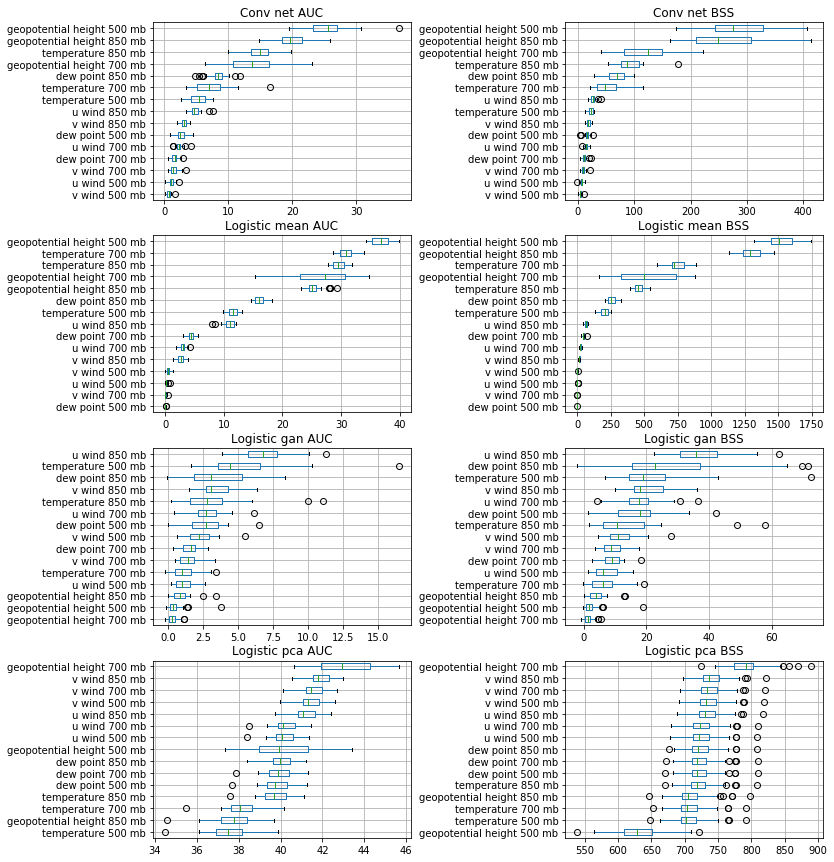

In [136]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
plt.subplots_adjust(wspace=0.6)
for m, model in enumerate(models):
    for s, score in enumerate(scores):
        rankings = imp_scores[model][score].mean(axis=0).sort_values().index
        imp_scores[model][score].loc[:, rankings].boxplot(ax=axes[m,s], vert=False)
        axes[m, s].set_title(model.replace("_", " ").capitalize() + " " + score.upper())
plt.savefig("var_imp_box.png", dpi=300, bbox_inches="tight")

In [137]:
mean_imp_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=float)
mean_imp_rank_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=int)
for model in models:
    mean_imp_matrix.loc[:, model] = imp_scores[model]["bss"].values.mean(axis=0)
    rank = np.argsort(imp_scores[model]["bss"].values.mean(axis=0))
    for r in range(rank.size):
        mean_imp_rank_matrix.loc[mean_imp_rank_matrix.index[rank[r]], model] = rank.size - r


In [93]:
mean_imp_matrix["conv_net"].values[np.argsort(mean_imp_matrix["conv_net"].values)]

array([  0.68831654,   1.13451656,   1.44212821,   1.55460714,
         2.2877488 ,   2.57388041,   3.05342006,   4.78460331,
         5.16755414,   7.18191937,   8.33550156,  13.72857337,
        14.8664198 ,  19.72752819,  25.62117955])

In [138]:
mean_imp_rank_matrix

,conv_net,logistic_mean,logistic_gan,logistic_pca
geopotential height 500 mb,1,1,14,15
geopotential height 700 mb,3,4,15,1
geopotential height 850 mb,2,2,13,12
temperature 500 mb,8,7,3,14
temperature 700 mb,6,3,12,13
temperature 850 mb,4,5,7,11
dew point 500 mb,10,15,6,10
dew point 700 mb,12,9,10,9
dew point 850 mb,5,6,2,8
u wind 500 mb,14,13,11,7


In [8]:
scaling_values = pd.read_csv("/d1/dgagne/spatial_storm_results_20171220/scaling_values.csv", index_col="Index")
scaling_values

,mean,std
Index,,
0,5788.919434,65.136246
1,3109.552979,49.678848
2,1481.663574,45.307823
3,261.454987,2.581064
4,279.288055,2.373210
5,289.850830,2.915570
6,253.631378,8.898883
7,274.562805,4.148108
8,285.562958,3.813218


In [4]:
cnn = load_model("/d1/dgagne/spatial_storm_results_20171220/hail_conv_net_sample_000.h5")

In [5]:
cnn_weights = cnn.layers[-2].get_weights()[0][:, 0]

In [122]:
cnn_weights.argsort()[::-1][0:10], cnn_weights[90]

(array([  90, 1583, 1960, 1923,  138,  459,  607, 1793,   10, 2030]),
 0.057643231)

(array([ 389.,  365.,  370.,  333.,  275.,  154.,  103.,   46.,    7.,    6.]),
 array([  6.72834358e-06,   5.85218002e-03,   1.16976317e-02,
          1.75430834e-02,   2.33885351e-02,   2.92339867e-02,
          3.50794384e-02,   4.09248901e-02,   4.67703418e-02,
          5.26157935e-02,   5.84612451e-02]),
 <a list of 10 Patch objects>)

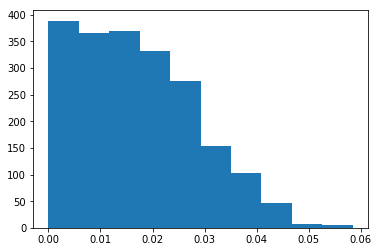

In [205]:
plt.hist(np.abs(cnn_weights))

In [169]:
encoding_data = pd.read_csv("/d1/dgagne/spatial_storm_results_20171220/encoding_conv_net_000.csv")

In [189]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
run_date = 2016052400
run_data = encoding_data.loc[encoding_data["run_dates"] == run_date]
enc_columns = ["E{0:03d}".format(x) for x in range(2048)]
pc = PCA(n_components=5)
pc_out = pc.fit_transform(run_data[enc_columns])

In [181]:
ts = TSNE(n_components=2)
ts_out = ts.fit_transform(run_data[enc_columns])

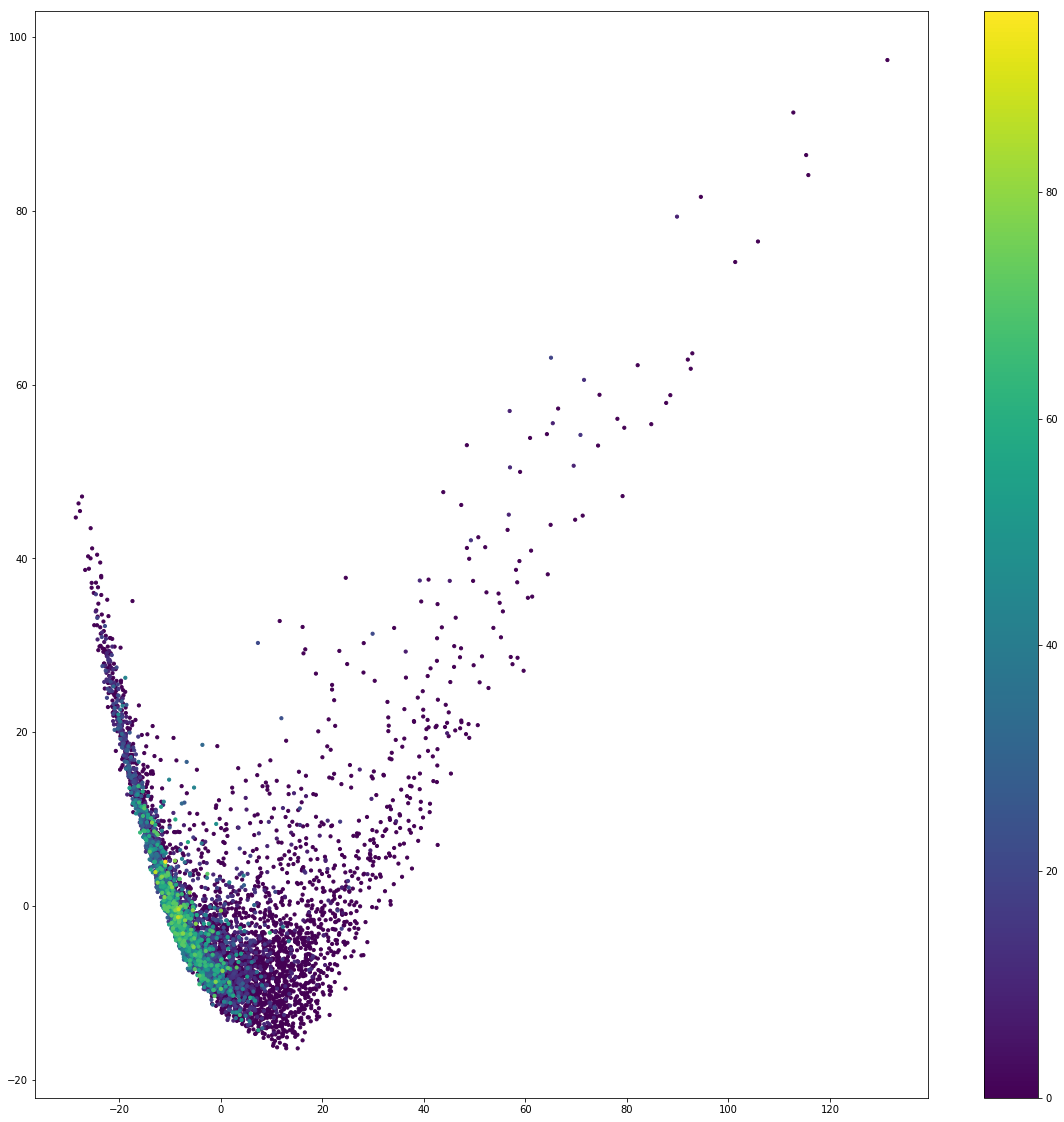

In [196]:
plt.figure(figsize=(20, 20))
size_order = np.argsort(run_data["max_hail_size"].values)
plt.scatter(pc_out[size_order, 0], pc_out[size_order,1], 10, run_data["max_hail_size"].values[size_order])
plt.colorbar()

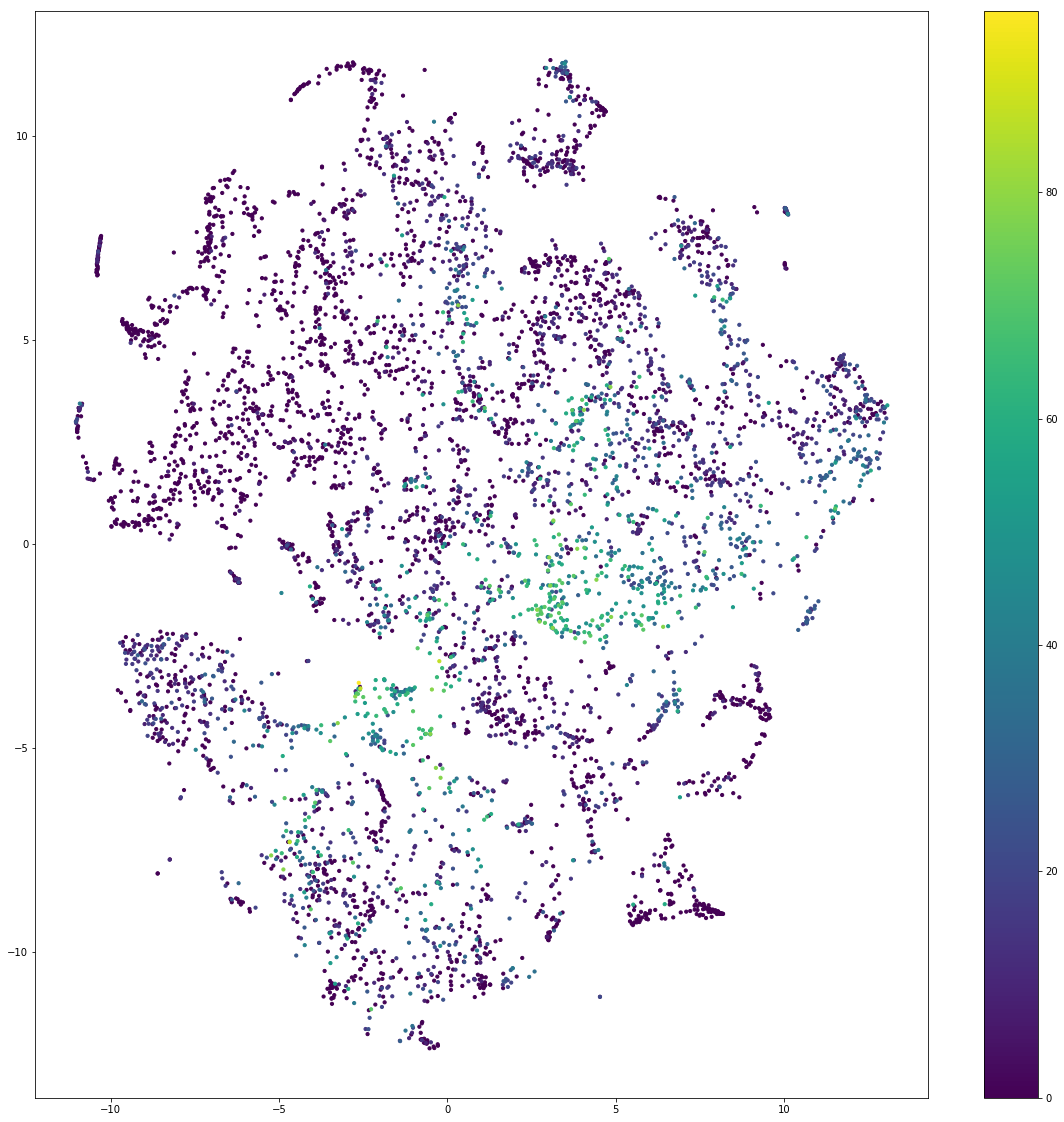

In [197]:
plt.figure(figsize=(20, 20))
size_order = np.argsort(run_data["max_hail_size"].values)
plt.scatter(ts_out[size_order, 0], ts_out[size_order,1], 10, run_data["max_hail_size"].values[size_order])
plt.colorbar()

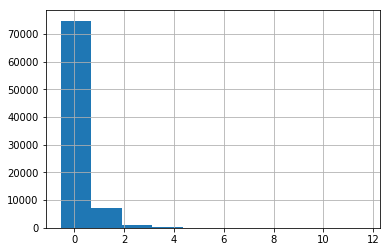

In [213]:
encoding_data[enc_columns].iloc[:, 90].hist()

In [221]:
def visualize_layer(cnn_model, neuron, out_prob, err_min=0.01, dropout=False, max_iter=500):
    layer_out = cnn_model.layers[-3].output[0, neuron]
    input_image = cnn_model.layers[0].input
    loss = (out_prob - layer_out) ** 2
    grads = K.gradients(loss, input_image)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    input_img_data = np.zeros((1, 32, 32, 15))
    #input_img_data = np.random.normal(size=(1, 32, 32, 15)) * 0.1
    step = 0.001
    loss_value = 100
    n = 0
    while loss_value > err_min and n < max_iter:
        print(loss_value)
        loss_value, grads_value = iterate([input_img_data, dropout])
        input_img_data -= grads_value * step
        n += 1
    return input_img_data


def smooth_channels(storm_cube, filter_sd):
    smooth_cube = np.zeros(storm_cube.shape)
    ds = disk(filter_sd)
    print(ds)
    for c in range(storm_cube.shape[-1]):
        out_channel = storm_cube[0, :, :, c]
        out_smooth = gaussian_filter(out_channel, 2)
        out_pos = np.zeros(out_channel.shape)
        out_neg = np.zeros(out_channel.shape)
        out_pos[out_smooth > 0] = out_channel[out_smooth > 0]
        out_neg[out_smooth < 0] = out_channel[out_smooth < 0]
        max_pos = maximum_filter(out_pos, footprint=ds)
        min_neg = minimum_filter(out_neg, footprint=ds)
        out_proc = np.zeros(out_channel.shape)
        out_proc[out_smooth > 0] = max_pos[out_smooth > 0]
        out_proc[out_smooth < 0] = min_neg[out_smooth < 0]
        smooth_cube[:, :, :, c] = out_proc
        #smooth_cube[:, :, :, c] = maximum_filter(storm_cube[:, :, :, c], filter_sd)
        #smooth_cube[:, :, :, c] /= smooth_cube[:, :, :, c].std()
    return smooth_cube

In [222]:
import keras.backend as K
out_image = visualize_layer(cnn, 90, 4)
out_smooth = smooth_channels(out_image, 2)
out_orig = unnormalize_multivariate_data(out_smooth, scaling_values=scaling_values)

100
16.3598
16.2263
16.0928
15.9599
15.8265
15.6896
15.5486
15.4077
15.2689
15.1298
14.9895
14.8479
14.7066
14.5703
14.4319
14.2916
14.1511
14.0115
13.8717
13.7319
13.5926
13.4532
13.3152
13.1777
13.0408
12.9039
12.7672
12.6311
12.4952
12.3579
12.2175
12.0767
11.938
11.7972
11.6483
11.4798
11.3158
11.1514
10.9869
10.7949
10.5685
10.3436
10.1062
9.87284
9.64257
9.40447
9.14029
8.87172
8.60646
8.31406
8.02196
7.72773
7.40777
7.09033
6.75247
6.43016
6.12843
5.83903
5.5572
5.27811
5.01696
4.76757
4.51637
4.26181
4.0115
3.75889
3.50854
3.25526
3.0119
2.77755
2.56113
2.35372
2.15363
1.96255
1.78404
1.60818
1.43059
1.24702
1.06791
0.904177
0.757767
0.624676
0.503008
0.394664
0.30018
0.219925
0.150872
0.0950607
0.0519523
0.0210574
[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]


4.02167


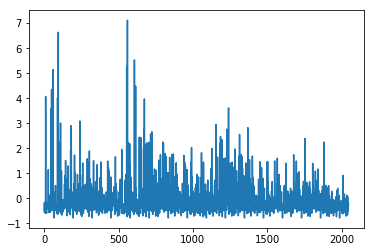

In [164]:
enc_func = K.function([cnn.input, K.learning_phase()], [cnn.layers[-3].output])
enc_out = enc_func([out_image, 0])[0]
print(enc_out[0, 90])
plt.plot(enc_out[0])

In [172]:
out_orig[0, :, :, 9]

array([[  9.99639773,   9.95236714,   9.90613444, ...,  10.07080364,
         10.07080364,  10.07080364],
       [  9.99081663,   9.93607852,   9.88355778, ...,  10.07080364,
         10.07080364,  10.07080364],
       [ 10.00121293,   9.91855122,   9.8489011 , ...,  10.07080364,
         10.07080364,  10.07080364],
       ..., 
       [ 10.07080364,  10.07080364,  10.07080364, ...,  10.07080364,
         10.07080364,  10.07080364],
       [ 10.07080364,  10.07080364,  10.07080364, ...,  10.07080364,
         10.07080364,  10.07080364],
       [ 10.07080364,  10.07080364,  10.07080364, ...,  10.07080364,
         10.07080364,  10.07080364]])

-0.519855255377 -0.519855255377


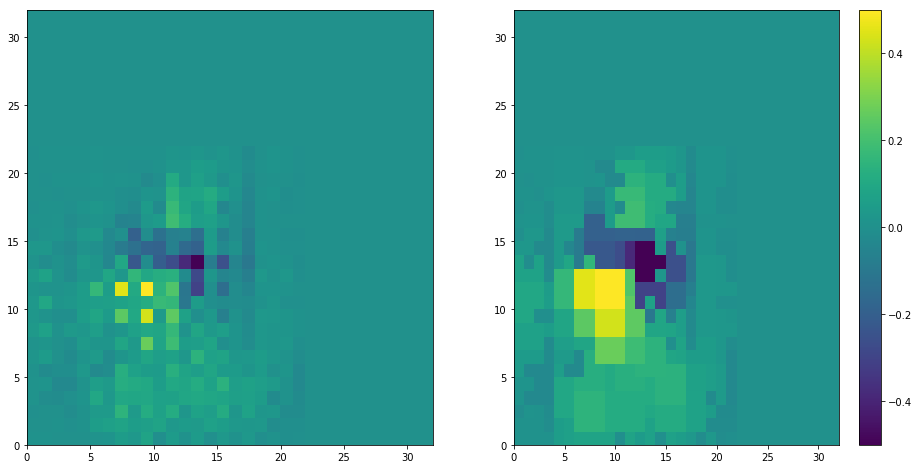

In [195]:
out_channel = out_image[0, :, :, index]
out_pos = np.zeros(out_channel.shape)
out_neg = np.zeros(out_channel.shape)
out_pos[out_channel > 0] = out_channel[out_channel > 0]
out_neg[out_channel < 0] = out_channel[out_channel < 0]
print(out_channel.min(), out_neg.min())
max_pos = maximum_filter(out_pos, 3)
min_neg = minimum_filter(out_neg, 3)
out_proc = np.zeros(out_channel.shape)
out_proc[out_channel > 0] = max_pos[out_channel > 0]
out_proc[out_channel < 0] = min_neg[out_channel < 0]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(out_channel, vmin=-0.5, vmax=0.5)
plt.subplot(1, 2, 2)
plt.pcolormesh(out_proc, vmin=-0.5, vmax=0.5)
plt.colorbar()

0.763314541895


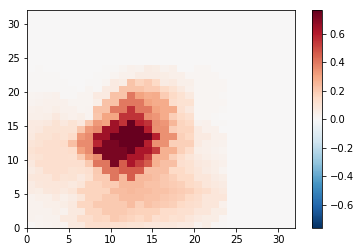

In [237]:
index = 5
v_max = np.max(np.abs(out_image[0, :, :, index]))
plt.pcolormesh(out_smooth[0, :, :, index], vmin=-v_max, vmax=v_max, cmap="RdBu_r")
plt.colorbar()
print(out_image[0, :, :, index].max())

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:664: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


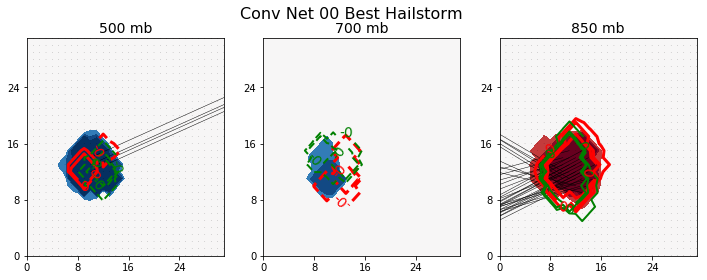

In [241]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    conts = [-0.5, -0.4, -0.3, 0.3, 0.4, 0.5]
    hght = plt.contourf(out_smooth[0, :, :, a], conts, extend="both", cmap="RdBu_r")
    tmpc = plt.contour(out_smooth[0, :, :, 3 + a], 
                       conts, linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp = plt.contour(out_smooth[0, :, :, 6 + a], conts, linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = out_smooth[0, :, :, 9 + a]
    v_g = out_smooth[0, :, :, 12 + a]
    #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 0.01
    #u_g[wind_mask] = 0
    #v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(0), fontsize=16, y=0.99)
plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_act_hail.png", dpi=200, bbox_inches="tight")

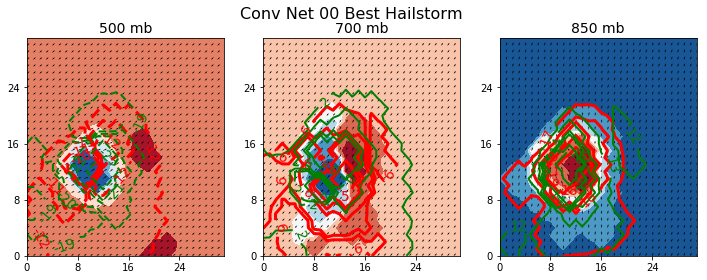

In [224]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght = plt.contourf(out_orig[0, :, :, a], 6, extend="both", cmap="RdBu_r")
    tmpc = plt.contour(out_orig[0, :, :, 3 + a] - 273, 6, linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp = plt.contour(out_orig[0, :, :, 6 + a] - 273, 6, linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = out_orig[0, :, :, 9 + a]
    v_g = out_orig[0, :, :, 12 + a]
    #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 1
    #u_g[wind_mask] = 0
    #v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(0), fontsize=16, y=0.99)
plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_act_hail_orig.png", dpi=200, bbox_inches="tight")

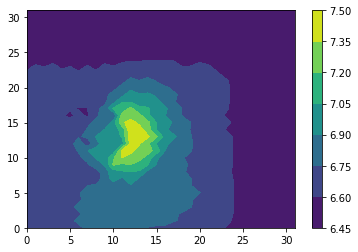

In [242]:
lapse_rate = -(out_orig[0, :, :, 3] - out_orig[0, :, :, 5]) / (out_orig[0, :, :, 0] - out_orig[0, :, :, 2]) * 1000
plt.contourf(lapse_rate)
plt.colorbar()

In [243]:
bwd = np.sqrt((out_orig[0, :, :, 9] - out_orig[0, :, :, 11]) ** 2 + (out_orig[0, :, :, 12] - out_orig[0, :, :, 14]) ** 2)

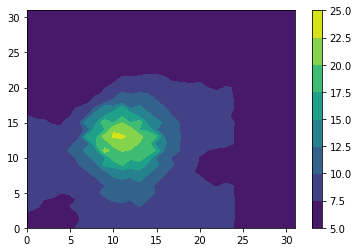

In [244]:
plt.contourf(bwd)
plt.colorbar()

0.0